## Welfare Range Calculations

### Set-Up

In [131]:
import squigglepy as sq
from squigglepy.numbers import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import platform

N = 10*K
PERCENTILES = [1, 5, 25, 50, 75, 95, 99]
ANIMALS = ["Pigs", "Chickens", "Carp", "Octopuses", "Shrimp", "BSF"]

### Import Data

In [132]:
pig_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('simulations', "Pigs")), 'rb'))
chicken_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('simulations', "Chickens")), 'rb'))
carp_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('simulations', "Carp")), 'rb'))
octopus_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('simulations', "Octopuses")), 'rb'))
shrimp_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('simulations', "Shrimp")), 'rb'))
bsf_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('simulations', "BSF")), 'rb'))

unknown_probabilities = pickle.load(open(os.path.join('inputs', "Unknown Probabilities.p"), 'rb'))

data = {'Pigs': {'Scores': pig_scores, 'Unknown Prob': unknown_probabilities['Pigs']}, 
        'Chickens': {'Scores': chicken_scores, 'Unknown Prob': unknown_probabilities['Chickens']}, 
        'Carp': {'Scores': carp_scores,  'Unknown Prob': unknown_probabilities['Carp']}, 
        'Octopuses': {'Scores': octopus_scores,  'Unknown Prob': unknown_probabilities['Octopuses']}, 
        'Shrimp': {'Scores': shrimp_scores, 'Unknown Prob': unknown_probabilities['Shrimp']}, 
        'BSF': {'Scores': bsf_scores, 'Unknown Prob': unknown_probabilities['BSF']}}

#print(test_simulations.test_wr_scores(data, overlap_dict, HC_WEIGHT, SENT_HC_WEIGHT, SPECIES))

def run_cmd(cmd):
    print(cmd)
    os.system(cmd)

if platform.system() == 'Darwin' or platform.system() == 'Linux':
    run_cmd('rm -rf outputs')
    run_cmd('mkdir outputs')
    run_cmd('rm -rf pickled_sent_conditioned_welfare_ranges')
    run_cmd('mkdir pickled_sent_conditioned_welfare_ranges')
    run_cmd('rm -rf pickled_sent_conditioned_welfare_ranges')
    run_cmd('mkdir pickled_sent_conditioned_welfare_ranges')
elif platform.system() == 'Windows':
    run_cmd('rmdir /Q /S outputs')
    run_cmd('mkdir outputs')
    run_cmd('rmdir /Q /S pickled_sent_conditioned_welfare_ranges')
    run_cmd('mkdir pickled_sent_conditioned_welfare_ranges')
    run_cmd('rmdir /Q /S pickled_sent_adjusted_welfare_ranges')
    run_cmd('mkdir pickled_sent_adjusted_welfare_ranges')
else:
    raise ValueError('Platform `{}` not supported'.format(platform.system()))

rmdir /Q /S outputs
mkdir outputs
rmdir /Q /S pickled_sent_conditioned_welfare_ranges
mkdir pickled_sent_conditioned_welfare_ranges
rmdir /Q /S pickled_sent_adjusted_welfare_ranges
mkdir pickled_sent_adjusted_welfare_ranges


### P(Sentience) Distributions

#### Distribution Sampling

In [133]:
pigs_psent = np.ones(N) - sq.sample(sq.lognorm(0.001, 0.2, rclip=.4), N)
chickens_psent = np.ones(N) - sq.sample(sq.lognorm(0.05, 0.25, lclip=0.01, rclip=0.5), N)
carp_psent = sq.sample(sq.norm(0.55, 0.85, lclip=0, rclip=1), N)
octopuses_psent = np.ones(N) - sq.sample(sq.lognorm(0.1, 0.5, lclip=0.01, rclip=.99), N)
shrimp_psent = sq.sample(sq.lognorm(0.2, 0.7, lclip = 0.01, rclip=1), N)
bsf_psent = sq.sample(sq.norm(0.1, 0.6, lclip = 0.01, rclip=1), N)

sent_models_dict = {"Pigs": pigs_psent, "Chickens": chickens_psent, "Carp": carp_psent, "Octopuses": octopuses_psent, "Shrimp": shrimp_psent, "BSF": bsf_psent}

#### P(Sentience) Summary Statistics

In [134]:
def get_percentiles_table(models_dict, animals):
    cols = ['1%', '5%', '25%', '50%', '75%', '95%', '99%', "Mean"]
    percentiles_dict = {}
    for animal in animals:
        percentiles = np.round(np.percentile(models_dict[animal], PERCENTILES), 2)
        percent_and_mean = np.append(percentiles, np.round(np.mean(models_dict[animal]),2))
        percentiles_dict[animal] = percent_and_mean
    df = pd.DataFrame.from_dict(percentiles_dict, columns=cols, orient='index')
    print("Probability of Sentience")
    df.to_csv(os.path.join("outputs", "P_sentience_percentiles.csv"))
    return df

get_percentiles_table(sent_models_dict, ANIMALS)

Probability of Sentience


,1%,5%,25%,50%,75%,95%,99%,Mean
Pigs,0.60,0.80,0.96,0.99,1.00,1.00,1.00,0.96
Chickens,0.64,0.75,0.84,0.89,0.92,0.95,0.97,0.87
Carp,0.49,0.55,0.64,0.70,0.76,0.85,0.91,0.70
Octopuses,0.31,0.50,0.68,0.78,0.84,0.90,0.93,0.75
Shrimp,0.15,0.20,0.29,0.37,0.49,0.71,0.92,0.40
BSF,0.01,0.10,0.25,0.35,0.45,0.59,0.70,0.35


### Sentience-Conditioned Welfare Ranges

#### Qualitative Proxies Model

In [135]:
def get_human_sum(model_proxies_lst):
    human_sum = len(model_proxies_lst)
    return human_sum

def one_sim_animal_wr(animal_scores, sim, human_sum):
    welfare_sum = 0
    for scores_list in animal_scores.values():
        score_i = scores_list[sim]
        welfare_sum += score_i

    welfare_range = welfare_sum/human_sum

    return welfare_range

def one_animal_welfare_ranges(animal_scores, model_proxies_lst):
    human_sum = get_human_sum(model_proxies_lst)
    animal_welfare_ranges = []
    for sim in range(N):
        animal_welfare_range_i = one_sim_animal_wr(animal_scores, sim, human_sum)
        animal_welfare_ranges.append(animal_welfare_range_i)
    return animal_welfare_ranges

def plot_range_distribution(species, welfare_range_list):
    welfare_range_array = np.array(welfare_range_list)
    plt.hist(welfare_range_array, bins=20, density=True)
    plt.axvline(x=np.percentile(welfare_range_array, PERCENTILES)[1], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(x=np.percentile(welfare_range_array, PERCENTILES)[5], color='k', linestyle='dashed', linewidth=1)
    plt.title("Distribution of {} Welfare Ranges".format(species))
    plt.show()
    print('-')

def one_animal_summary_stats(species, welfare_range_list, to_print=False):
    welfare_range_array = np.array(welfare_range_list)
    percentiles = np.percentile(welfare_range_array, PERCENTILES)
    mean = np.mean(welfare_range_array)
    fifth_percentile = percentiles[1]
    twenty_fifth_percentile = percentiles[2]
    seventy_fifth_percentile = percentiles[4]
    ninty_fifth_percentile = percentiles[5]
    median = percentiles[3]
    stats_tuple = (mean, fifth_percentile, twenty_fifth_percentile, median, seventy_fifth_percentile, ninty_fifth_percentile)
    if to_print:
        print("Number samples: {}".format(len(welfare_range_array)))
        print("Mean welfare range: {}".format(mean))
        print("5th-percentile welfare range: {}".format(fifth_percentile))
        print("25th-percentile welfare range: {}".format(twenty_fifth_percentile))
        print("50th-percentile welfare range: {}".format(median))
        print("75th-percentile welfare range: {}".format(seventy_fifth_percentile))
        print("95th-percentile welfare range: {}".format(ninty_fifth_percentile))
    return stats_tuple

def get_qualitative_welfare_ranges(data, ANIMALS, to_plot=False):
    model_proxies_lst = data['Pigs']['Scores'].keys()
    means = []
    fifth_percentiles = []
    twenty_fifth_percentiles = []
    medians = []
    seventy_fifth_percentiles = []
    ninty_fifth_percentiles = []

    welfare_ranges_all_animals = {}

    for animal in ANIMALS:
        animal_scores = data[animal]['Scores']
        animal_welfare_ranges = one_animal_welfare_ranges(animal_scores, model_proxies_lst)
        welfare_ranges_all_animals[animal] = animal_welfare_ranges
        pickle.dump(np.array(animal_welfare_ranges), open(os.path.join('pickled_sent_conditioned_welfare_ranges', '{}_qual_model_welfare_ranges.p'.format(animal)), 'wb'))
        if to_plot:
            plot_range_distribution(animal, animal_welfare_ranges)
        animal_stats = one_animal_summary_stats(animal, animal_welfare_ranges)
        means.append(round(animal_stats[0],3))
        fifth_percentiles.append(round(animal_stats[1],3))
        twenty_fifth_percentiles.append(round(animal_stats[2],3))
        medians.append(round(animal_stats[3],3))
        seventy_fifth_percentiles.append(round(animal_stats[4],3))
        ninty_fifth_percentiles.append(round(animal_stats[5],3))

    cols = ["Animals", 'Mean', '5%', '25%', '50%', '75%', '95%']
    welfare_range_stats_df = pd.DataFrame(list(zip(ANIMALS, means, fifth_percentiles, twenty_fifth_percentiles, medians, seventy_fifth_percentiles, ninty_fifth_percentiles)), columns=cols)
    welfare_range_stats_df.sort_values("50%", ascending=False)
    welfare_range_stats_df.to_csv(os.path.join("outputs", "Qualitative Model - Sentience-Conditioned Welfare Ranges.csv"))
    return welfare_range_stats_df, welfare_ranges_all_animals

qualitative_welfare_range_stats_df, qualitative_welfare_ranges_all_animals = get_qualitative_welfare_ranges(data, ANIMALS, to_plot=False)
print(qualitative_welfare_range_stats_df)




     Animals   Mean     5%    25%    50%    75%    95%
0       Pigs  0.571  0.478  0.543  0.565  0.609  0.652
1   Chickens  0.577  0.500  0.543  0.587  0.609  0.652
2       Carp  0.424  0.348  0.391  0.435  0.457  0.500
3  Octopuses  0.422  0.348  0.391  0.413  0.457  0.500
4     Shrimp  0.174  0.109  0.152  0.174  0.196  0.217
5        BSF  0.193  0.130  0.174  0.196  0.217  0.239


### Equality-Among-Sentient-Animals Model

In [136]:
def get_equality_welfare_ranges():
    equality_welfare_ranges = {}
    for animal in ANIMALS:
        equality_welfare_ranges[animal] = 1
    return equality_welfare_ranges

### Neuron Count Model

In [137]:
def get_geometric_mean_of_row(df, animal, weights):
    animal_proxy_lst = df.loc[df['Animals'] == animal].values.tolist()[0][1:4]
    animal_geom_mean = np.exp(np.log(animal_proxy_lst).dot(weights))
    return animal_geom_mean

def get_neuron_count_welfare_ranges():
    neuron_count_df = pd.read_csv(os.path.join('inputs', 'Neuron Count Data.csv'))
    weights = (0.2, 0.4, 0.4)
    human_geom_mean = get_geometric_mean_of_row(neuron_count_df, 'Humans', weights)

    nc_welfare_ranges_dict = {}
    for animal in ANIMALS:
        animal_geom_mean = get_geometric_mean_of_row(neuron_count_df, animal, weights)
        welfare_range = animal_geom_mean/human_geom_mean
        nc_welfare_ranges_dict[animal] = welfare_range
    return nc_welfare_ranges_dict


### Sentience-Confitioned Welfare Ranges

#### Mixture Model Method

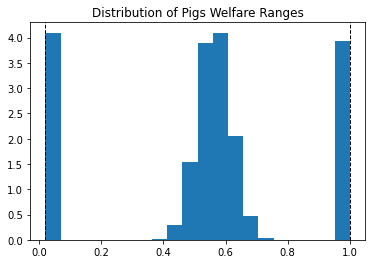

-


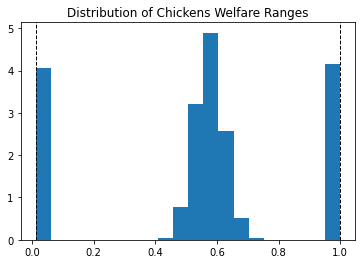

-


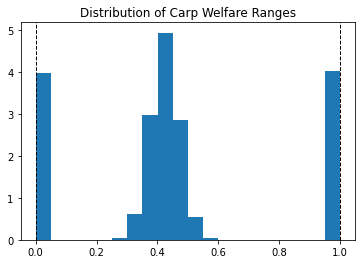

-


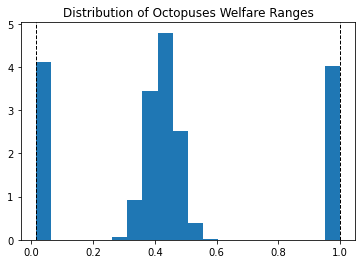

-


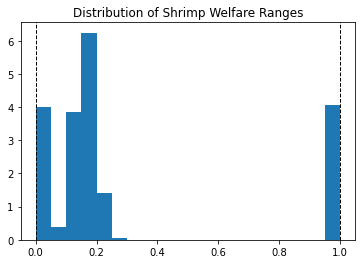

-


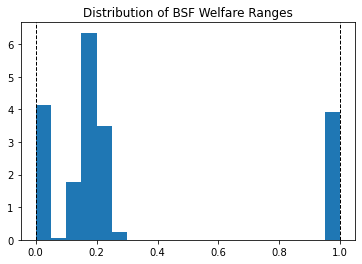

-
     Animals   Mean     5%    25%    50%    75%  95%
0       Pigs  0.539  0.020  0.491  0.563  0.636  1.0
1   Chickens  0.549  0.013  0.512  0.576  0.642  1.0
2       Carp  0.456  0.000  0.361  0.425  0.489  1.0
3  Octopuses  0.456  0.015  0.359  0.425  0.487  1.0
4     Shrimp  0.300  0.000  0.117  0.162  0.210  1.0
5        BSF  0.306  0.000  0.136  0.184  0.228  1.0


In [138]:
def get_model_results():
    qualitative_welfare_ranges_df, qualitative_welfare_ranges_dict = get_qualitative_welfare_ranges(data, ANIMALS)
    equality_welfare_ranges = get_equality_welfare_ranges()
    neuron_count_welfare_ranges = get_neuron_count_welfare_ranges()
    model_results = {'Qualitative': (qualitative_welfare_ranges_df, qualitative_welfare_ranges_dict), 
                     'Equality': equality_welfare_ranges, 
                     'Neuron Count': neuron_count_welfare_ranges}
        
    
    return model_results

def mixture_one_animal(model_results, animal, weights):
    qual_model_df = model_results['Qualitative'][0]
    equality_results = model_results['Equality'][animal]
    neuron_count_results = model_results['Neuron Count'][animal]

    animal_qualitative_row = qual_model_df.loc[qual_model_df['Animals'] == animal].values.tolist()[0]
    animal_fifth_pct = animal_qualitative_row[2]
    animal_ninty_fifth_pct = animal_qualitative_row[6]

    qual_model = sq.norm(animal_fifth_pct, animal_ninty_fifth_pct, lclip=0)
    equality_model = sq.uniform(equality_results, equality_results)
    neuron_count_model = sq.uniform(neuron_count_results, neuron_count_results)

    mixture_model = sq.mixture([qual_model, equality_model, neuron_count_model], weights)

    mixture_welfare_ranges = sq.sample(mixture_model, N)

    return mixture_welfare_ranges

weights = [0.6, 0.2, 0.2]

def get_mixture_welfare_ranges(weights, to_plot=True):
    means = []
    fifth_percentiles = []
    twenty_fifth_percentiles = []
    medians = []
    seventy_fifth_percentiles = []
    ninty_fifth_percentiles = []

    model_results = get_model_results()

    mixture_welfare_range_results = {}
    
    for animal in ANIMALS:
        animal_mixture_wr_lst = mixture_one_animal(model_results, animal, weights)
        mixture_welfare_range_results[animal] = animal_mixture_wr_lst
        animal_stats = one_animal_summary_stats(animal, animal_mixture_wr_lst, to_print=False)
        pickle.dump(np.array(animal_mixture_wr_lst), open(os.path.join('pickled_sent_conditioned_welfare_ranges', '{}_mixture_model_welfare_ranges.p'.format(animal)), 'wb'))
        means.append(round(animal_stats[0],3))
        fifth_percentiles.append(round(animal_stats[1],3))
        twenty_fifth_percentiles.append(round(animal_stats[2],3))
        medians.append(round(animal_stats[3],3))
        seventy_fifth_percentiles.append(round(animal_stats[4],3))
        ninty_fifth_percentiles.append(round(animal_stats[5],3))
    
    if to_plot:
        for animal in ANIMALS:
            plot_range_distribution(animal, mixture_welfare_range_results[animal])
    
    cols = ["Animals", 'Mean', '5%', '25%', '50%', '75%', '95%']
    mixture_welfare_range_stats_df = pd.DataFrame(list(zip(ANIMALS, means, fifth_percentiles, twenty_fifth_percentiles, medians, seventy_fifth_percentiles, ninty_fifth_percentiles)), columns=cols)
    mixture_welfare_range_stats_df.sort_values("50%", ascending=False)
    mixture_welfare_range_stats_df.to_csv(os.path.join("outputs", "Mixture Model - Sentience-Conditioned Welfare Ranges.csv"))
    return mixture_welfare_range_stats_df, mixture_welfare_range_results

print(get_mixture_welfare_ranges(weights)[0])



#### Geometric Mean Method

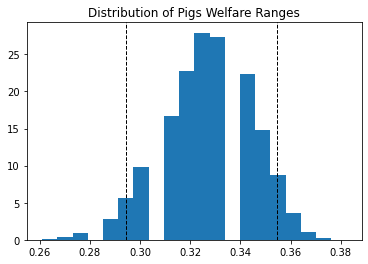

-


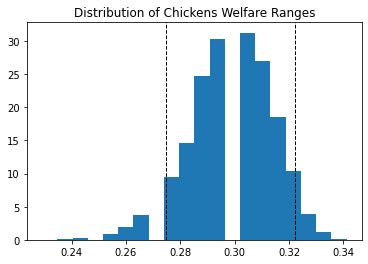

-


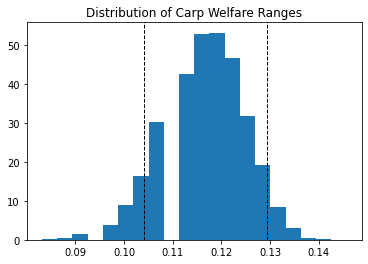

-


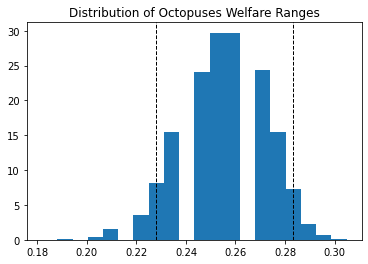

-


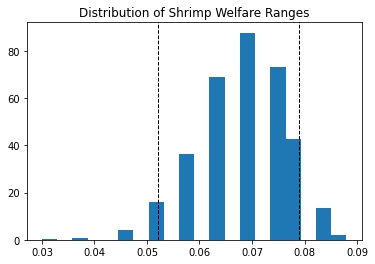

-


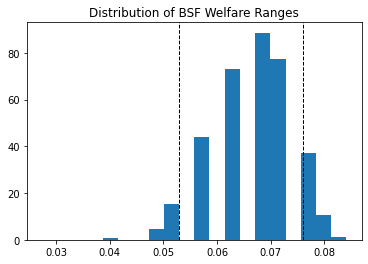

-


In [139]:
def geometric_mean_welfare_ranges(data, ANIMALS, to_plot=False):
    means = []
    fifth_percentiles = []
    twenty_fifth_percentiles = []
    medians = []
    seventy_fifth_percentiles = []
    ninty_fifth_percentiles = []

    model_weights = {'Qualitative': 0.6, 'Equality': 0.2, 'Neuron Count': 0.2}

    model_results = get_model_results()
    qual_wr_lst = model_results['Qualitative'][1]
    equality_wr_lst = model_results['Equality']
    neuron_count_wr_lst = model_results['Neuron Count']

    q_wt = model_weights['Qualitative']
    e_wt = model_weights['Equality']
    nc_wt = model_weights['Neuron Count']

    geom_mean_welfare_ranges = {}

    for animal in ANIMALS: 
        animal_qualitative_welfare_ranges = qual_wr_lst[animal]
        animal_equality_welfare_range = equality_wr_lst[animal]
        animal_neuron_count_welfare_range = neuron_count_wr_lst[animal]

        animal_geom_mean_welfare_range = []

        for i in range(N):
            animal_welfare_range_i = (animal_qualitative_welfare_ranges[i])**(q_wt*animal_equality_welfare_range**e_wt)*(animal_neuron_count_welfare_range**nc_wt)
            animal_geom_mean_welfare_range.append(animal_welfare_range_i)
        pickle.dump(np.array(animal_geom_mean_welfare_range), open(os.path.join('pickled_sent_conditioned_welfare_ranges', '{}_geom_mean_welfare_ranges.p'.format(animal)), 'wb'))
        geom_mean_welfare_ranges[animal] = animal_geom_mean_welfare_range
        animal_stats = one_animal_summary_stats(animal, animal_geom_mean_welfare_range, to_print=False)
        means.append(round(animal_stats[0],3))
        fifth_percentiles.append(round(animal_stats[1],3))
        twenty_fifth_percentiles.append(round(animal_stats[2],3))
        medians.append(round(animal_stats[3],3))
        seventy_fifth_percentiles.append(round(animal_stats[4],3))
        ninty_fifth_percentiles.append(round(animal_stats[5],3))

    if to_plot:
        for animal in ANIMALS:
            plot_range_distribution(animal, geom_mean_welfare_ranges[animal])

    cols = ["Animals", 'Mean', '5%', '25%', '50%', '75%', '95%']
    geom_mean_welfare_range_stats_df = pd.DataFrame(list(zip(ANIMALS, means, fifth_percentiles, twenty_fifth_percentiles, medians, seventy_fifth_percentiles, ninty_fifth_percentiles)), columns=cols)
    geom_mean_welfare_range_stats_df.sort_values("50%", ascending=False)
    geom_mean_welfare_range_stats_df.to_csv(os.path.join("outputs", "Geometric Mean Model - Sentience-Conditioned Welfare Ranges.csv"))
    return geom_mean_welfare_range_stats_df, geom_mean_welfare_ranges
    
    
geom_mean_welfare_range_stats_df, geom_mean_welfare_ranges = geometric_mean_welfare_ranges(data, ANIMALS, to_plot=True)

## P(Sentience)-Adjusted Welfare Ranges

#### Mixture Model

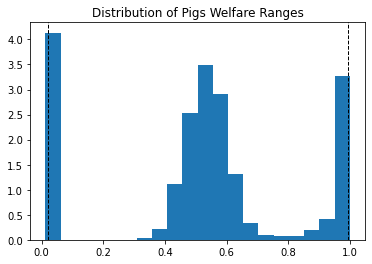

-


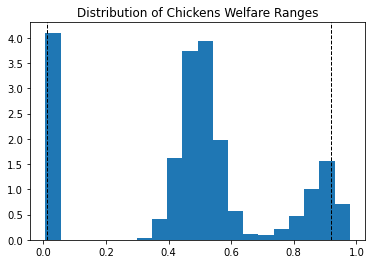

-


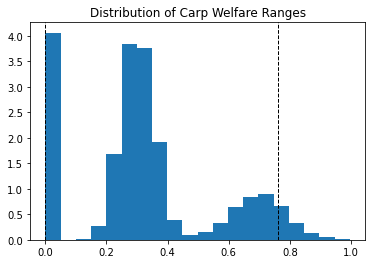

-


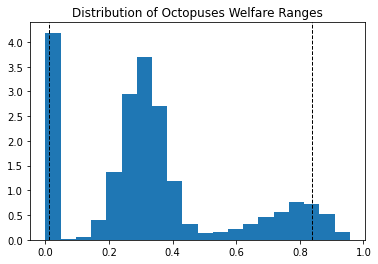

-


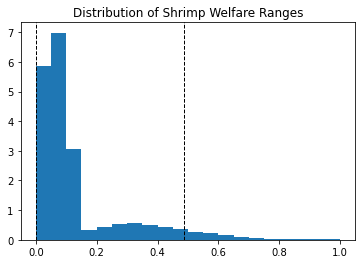

-


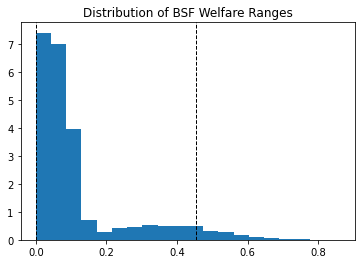

-
     Animals   Mean     5%    25%    50%    75%    95%
0       Pigs  0.517  0.019  0.444  0.536  0.626  0.996
1   Chickens  0.476  0.011  0.420  0.497  0.575  0.920
2       Carp  0.322  0.000  0.228  0.301  0.378  0.763
3  Octopuses  0.335  0.010  0.219  0.307  0.390  0.839
4     Shrimp  0.128  0.000  0.038  0.080  0.123  0.486
5        BSF  0.114  0.000  0.025  0.070  0.112  0.455


In [140]:
def sent_adj_qualitative_welfare_ranges(ANIMALS):
    means = []
    fifth_percentiles = []
    twenty_fifth_percentiles = []
    medians = []
    seventy_fifth_percentiles = []
    ninty_fifth_percentiles = []

    sent_adj_qual_ranges_all_animals = {}

    for animal in ANIMALS:
        conditioned_animal_welfare_ranges = pickle.load(open(os.path.join('pickled_sent_conditioned_welfare_ranges', '{}_qual_model_welfare_ranges.p'.format(animal)), 'rb'))
        animal_psent = sent_models_dict[animal]
        sent_adj_animal_welfare_ranges = conditioned_animal_welfare_ranges*animal_psent
        sent_adj_qual_ranges_all_animals[animal] =sent_adj_animal_welfare_ranges
        pickle.dump(np.array(sent_adj_animal_welfare_ranges), open(os.path.join('pickled_sent_adjusted_welfare_ranges', '{}_qual_model_welfare_ranges.p'.format(animal)), 'wb'))
        sent_adj_animal_stats = one_animal_summary_stats(animal, sent_adj_animal_welfare_ranges)
        means.append(round(sent_adj_animal_stats[0],3))
        fifth_percentiles.append(round(sent_adj_animal_stats[1],3))
        twenty_fifth_percentiles.append(round(sent_adj_animal_stats[2],3))
        medians.append(round(sent_adj_animal_stats[3],3))
        seventy_fifth_percentiles.append(round(sent_adj_animal_stats[4],3))
        ninty_fifth_percentiles.append(round(sent_adj_animal_stats[5],3))

    cols = ["Animals", 'Mean', '5%', '25%', '50%', '75%', '95%']
    sent_adj_qual_range_stats_df = pd.DataFrame(list(zip(ANIMALS, means, fifth_percentiles, twenty_fifth_percentiles, medians, seventy_fifth_percentiles, ninty_fifth_percentiles)), columns=cols)
    sent_adj_qual_range_stats_df.sort_values("50%", ascending=False)
    sent_adj_qual_range_stats_df.to_csv(os.path.join("outputs", "Qualitative Model - P_Sentience-Adjusted Welfare Ranges.csv"))
    return sent_adj_qual_range_stats_df, sent_adj_qual_ranges_all_animals

def one_animal_sentience_adjustment(animal, animal_equality_range, animal_neuron_count_range, sent_adj_qual_animal_ranges):
    animal_psent = sent_models_dict[animal]
    sent_adj_animal_equality_ranges = animal_equality_range*animal_psent
    sent_adj_animal_neuron_count_ranges = animal_neuron_count_range*animal_psent

    sent_adj_animal_model_results = {'Qualitative': sent_adj_qual_animal_ranges,
                                      'Equality': sent_adj_animal_equality_ranges, 
                                      'Neuron Count': sent_adj_animal_neuron_count_ranges}
    
    return sent_adj_animal_model_results

def one_animal_sent_adj_mixture_results(animal, animal_equality_range, animal_neuron_count_range, animal_sent_adj_qual_ranges, weights):
    sent_adj_animal_model_results = one_animal_sentience_adjustment(animal, animal_equality_range, animal_neuron_count_range, animal_sent_adj_qual_ranges)

    animal_sent_adj_equality_results = sent_adj_animal_model_results['Equality']
    animal_sent_adj_neuron_count_results = sent_adj_animal_model_results['Neuron Count']
    animal_sent_adj_qual_results = sent_adj_animal_model_results['Qualitative']

    animal_qual_fifth_pct = np.percentile(animal_sent_adj_qual_results, 5)
    animal_qual_ninty_fifth_pct = np.percentile(animal_sent_adj_qual_results, 95)

    qual_model = sq.norm(animal_qual_fifth_pct, animal_qual_ninty_fifth_pct, lclip=0)
    equality_model = sq.uniform(animal_sent_adj_equality_results, animal_sent_adj_equality_results)
    neuron_count_model = sq.uniform(animal_sent_adj_neuron_count_results, animal_sent_adj_neuron_count_results)

    mixture_model = sq.mixture([qual_model, equality_model, neuron_count_model], weights)

    sent_adj_mixture_welfare_ranges = sq.sample(mixture_model, N)

    return sent_adj_mixture_welfare_ranges

def all_animals_sent_adj_mixture_model(to_plot=True):
    means = []
    fifth_percentiles = []
    twenty_fifth_percentiles = []
    medians = []
    seventy_fifth_percentiles = []
    ninty_fifth_percentiles = []
    
    sent_adj_qualitative_wrs_all_animals = sent_adj_qualitative_welfare_ranges(ANIMALS)[1]
    equality_wr_lst = get_equality_welfare_ranges()
    neuron_count_wr_lst = get_neuron_count_welfare_ranges()

    sent_adj_wr_dict = {}

    for animal in ANIMALS:
        animal_sent_adj_qual_ranges = sent_adj_qualitative_wrs_all_animals[animal]
        animal_equality_range = equality_wr_lst[animal]
        animal_neuron_count_range = neuron_count_wr_lst[animal]

        sent_adj_animal_mixture_wr_lst = one_animal_sent_adj_mixture_results(animal, animal_equality_range, animal_neuron_count_range, animal_sent_adj_qual_ranges, weights)
        sent_adj_wr_dict[animal] = sent_adj_animal_mixture_wr_lst
        
        sent_adj_animal_stats = one_animal_summary_stats(animal, sent_adj_animal_mixture_wr_lst, to_print=False)
        pickle.dump(np.array(sent_adj_animal_mixture_wr_lst), open(os.path.join('pickled_sent_adjusted_welfare_ranges', '{}_mixture_model_welfare_ranges.p'.format(animal)), 'wb'))
        means.append(round(sent_adj_animal_stats[0],3))
        fifth_percentiles.append(round(sent_adj_animal_stats[1],3))
        twenty_fifth_percentiles.append(round(sent_adj_animal_stats[2],3))
        medians.append(round(sent_adj_animal_stats[3],3))
        seventy_fifth_percentiles.append(round(sent_adj_animal_stats[4],3))
        ninty_fifth_percentiles.append(round(sent_adj_animal_stats[5],3))

    if to_plot:
        for animal in ANIMALS:
            plot_range_distribution(animal, sent_adj_wr_dict[animal])
            
    cols = ["Animals", 'Mean', '5%', '25%', '50%', '75%', '95%']
    sent_adj_mixture_welfare_range_stats_df = pd.DataFrame(list(zip(ANIMALS, means, fifth_percentiles, twenty_fifth_percentiles, medians, seventy_fifth_percentiles, ninty_fifth_percentiles)), columns=cols)
    sent_adj_mixture_welfare_range_stats_df.sort_values("50%", ascending=False)
    sent_adj_mixture_welfare_range_stats_df.to_csv(os.path.join("outputs", "Mixture Model - P_Sentience-Adjusted Welfare Ranges.csv"))
    return sent_adj_mixture_welfare_range_stats_df, sent_adj_wr_dict

print(all_animals_sent_adj_mixture_model()[0])


### Geometric Mean

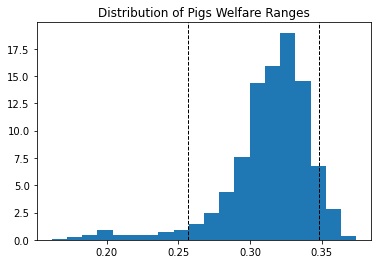

-


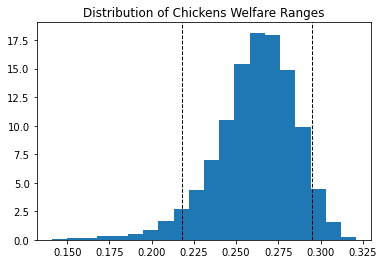

-


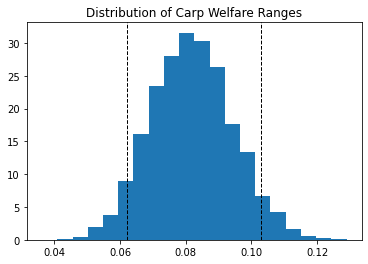

-


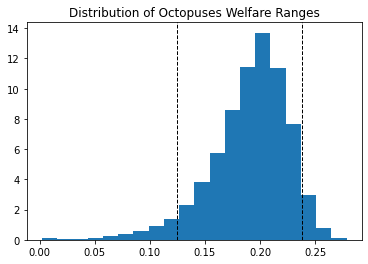

-


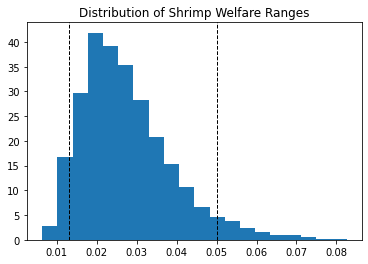

-


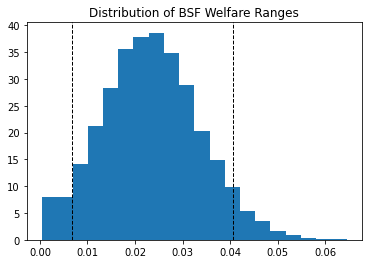

-
     Animals   Mean     5%    25%    50%    75%    95%
0       Pigs  0.313  0.257  0.302  0.318  0.332  0.348
1   Chickens  0.261  0.218  0.248  0.264  0.278  0.295
2       Carp  0.082  0.062  0.073  0.082  0.090  0.103
3  Octopuses  0.191  0.125  0.172  0.196  0.215  0.238
4     Shrimp  0.028  0.013  0.019  0.025  0.034  0.050
5        BSF  0.023  0.007  0.016  0.023  0.030  0.041


In [141]:
def all_animals_sent_adj_geometric_mean_model(to_plot=True):
    means = []
    fifth_percentiles = []
    twenty_fifth_percentiles = []
    medians = []
    seventy_fifth_percentiles = []
    ninty_fifth_percentiles = []
    
    sent_adj_qualitative_wrs_all_animals = sent_adj_qualitative_welfare_ranges(ANIMALS)[1]
    equality_wr_lst = get_equality_welfare_ranges()
    neuron_count_wr_lst = get_neuron_count_welfare_ranges()

    sent_adj_geom_mean_wr_dict = {}

    weights = [0.6, 0.2, 0.2]

    for animal in ANIMALS:
        animal_sent_adj_qual_ranges = sent_adj_qualitative_wrs_all_animals[animal]
        animal_equality_range = equality_wr_lst[animal]
        animal_neuron_count_range = neuron_count_wr_lst[animal]

        animal_sent_adj_model_results = one_animal_sentience_adjustment(animal, animal_equality_range, animal_neuron_count_range, animal_sent_adj_qual_ranges)
        animal_sent_adj_equality_results = animal_sent_adj_model_results['Equality']
        animal_sent_adj_neuron_count_results = animal_sent_adj_model_results['Neuron Count']

        sent_adj_animal_geom_mean_lst = []
        for i in range(N):
            qual_result_i = animal_sent_adj_qual_ranges[i]
            equality_result_i = animal_sent_adj_equality_results[i]
            neuron_count_result_i = animal_sent_adj_neuron_count_results[i]
            geom_mean_result_i = np.exp(np.log(qual_result_i)*0.6 + np.log(equality_result_i)*0.2 + np.log(neuron_count_result_i)*0.2)
            sent_adj_animal_geom_mean_lst.append(geom_mean_result_i)

        sent_adj_geom_mean_wr_dict[animal] = sent_adj_animal_geom_mean_lst
        
        sent_adj_animal_stats = one_animal_summary_stats(animal, sent_adj_animal_geom_mean_lst, to_print=False)
        pickle.dump(np.array(sent_adj_animal_geom_mean_lst), open(os.path.join('pickled_sent_adjusted_welfare_ranges', '{}_geom_mean_welfare_ranges.p'.format(animal)), 'wb'))
        means.append(round(sent_adj_animal_stats[0],3))
        fifth_percentiles.append(round(sent_adj_animal_stats[1],3))
        twenty_fifth_percentiles.append(round(sent_adj_animal_stats[2],3))
        medians.append(round(sent_adj_animal_stats[3],3))
        seventy_fifth_percentiles.append(round(sent_adj_animal_stats[4],3))
        ninty_fifth_percentiles.append(round(sent_adj_animal_stats[5],3))
    
    if to_plot:
        for animal in ANIMALS:
            plot_range_distribution(animal, sent_adj_geom_mean_wr_dict[animal])
    
    cols = ["Animals", 'Mean', '5%', '25%', '50%', '75%', '95%']
    sent_adj_geom_mean_welfare_range_stats_df = pd.DataFrame(list(zip(ANIMALS, means, fifth_percentiles, twenty_fifth_percentiles, medians, seventy_fifth_percentiles, ninty_fifth_percentiles)), columns=cols)
    sent_adj_geom_mean_welfare_range_stats_df.sort_values("50%", ascending=False)
    sent_adj_geom_mean_welfare_range_stats_df.to_csv(os.path.join("outputs", "Mixture Model - P_Sentience-Adjusted Welfare Ranges.csv"))
    return sent_adj_geom_mean_welfare_range_stats_df, sent_adj_geom_mean_wr_dict

print(all_animals_sent_adj_geometric_mean_model()[0])